In [1]:
import sys
sys.path.append('/home/jlbernal/lim/')
sys.path.append('/home/jlbernal/preLIMinary/')
from LIM_lightcone import paint_lightcone,make_survey,make_measurements
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as cu
from scipy.interpolate import interp2d,interp1d
from scipy.optimize import curve_fit
import math
from lim import lim

from nbodykit.algorithms import FFTPower

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as clrs
import matplotlib.cm as cmap
import matplotlib.patches as patches
from matplotlib.patches import Rectangle as rect
from matplotlib.collections import PatchCollection

colors = ['#8a1f1f','#79a43a','#C59D34','#171782', '#cf6717','#ad6faa',
          '#009999','#828282']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 2.

%matplotlib inline


In [2]:
def linear_color(col1,col2):
    cmap = clrs.LinearSegmentedColormap.from_list("", [col1,col2])
    return cmap

#############################################

def SFR_Mz_2dinterp(M,z,SFR_file):
    '''
    Returns SFR(M,z) interpolated from tables of 1+z, log10(Mhalo/Msun) and 
    log10(SFR / (Msun/yr)), in three columns, where 1+z is the innermost index 
    (the one running fast compared with the mass)
    '''
    #SFR_folder = os.path.dirname(os.path.realpath(__file__)).split("source")[0]+'SFR_tables/'
    #try:
    #    x = np.loadtxt(SFR_folder+SFR_file)
    #except:
    x = np.loadtxt(SFR_file)
    zb = np.unique(x[:,0])-1.
    logMb = np.unique(x[:,1])
    logSFRb = x[:,2].reshape(len(zb),len(logMb),order='F')
    
    logSFR_interp = interp2d(logMb,zb,logSFRb,bounds_error=False,fill_value=-40.)
    
    if 'sfr_table_Behroozi' in SFR_file:
        M *= 0.678
        
    try:
        logM = np.log10((M).value)
    except:
        logM = np.log10(M)
    if np.array(z).size>1:
        SFR = np.zeros(logM.size)
        for ii in range(0,logM.size):
            SFR[ii] = 10.**logSFR_interp(logM[ii],z[ii])
    else:
        SFR = 10.**logSFR_interp(logM,z)
    
    return SFR

# Setting parameters

In [3]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def lim_params(SFR_file, Tsys,z,Dz,sigma_scatter=0.3,sig_SFR=0.6,
              Nfeeds = 1000, beam = 4, tobs = 1000,
              Omega_field = 100,dnu=10):
    #Setting line model and observational parameters. Default with RSD, smooth, one_halo, at z=2.5.
    cosmo_fid = dict(cosmo_input_camb={'H0':67.8,'ombh2':0.02312,'omch2':0.118002988,
                      'As':2.23832e-9,'ns':0.96,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
        
    nu=115.271*u.GHz
    nuObs, Dnu = Dnu_from_Dz(nu, z, Dz)
    model_params = dict(nu=nu, nuObs=nuObs, 
                        sigma_scatter=sigma_scatter,
                        hmf_model='Tinker', 
                        bias_model='Tinker10', 
                        model_type='ML',
                        Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                        model_par={'alpha':1.37, 'beta':-1.74, 'dMF':1.0,'SFR_file':SFR_file,'sig_SFR':sig_SFR},
                        model_name='TonyLi', 
                        do_onehalo=True, do_RSD=True, smooth=False, 
                        kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1, 
                        nk=512, nmu=10000, 
                        nT=2**21, Tmin_VID = 1.0e-4*u.uK)
    obs_params = dict(Delta_nu=Dnu, dnu=dnu*u.MHz, 
                      Tsys_NEFD=Tsys*u.K, 
                      Nfeeds=Nfeeds, 
                      beam_FWHM=beam*u.arcmin, 
                      tobs=tobs*u.hr,
                      Omega_field=Omega_field*u.deg**2, 
                      Nfield=1)
                
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

def LC_params(do_exSFR, exSFR, exSFR_pars, Tsys,
              zmin_obs, zmax_obs,zmin=2.2,zmax=3.5,
              sigma_scatter=0.3,sig_SFR=0.6,
              Nfeeds = 1000, beam = 4, tobs = 1000,
              alpha = 1.37, beta = -1.74,
              dnu=10,
              RAObs_edge = 4.5, DECObs_edge = 4.5,smooth=False):
    nu_CO=115.271*u.GHz

    model_params=dict(halo_lightcone_dir='/home/jlbernal/LightCone_S82_UM/', 
                      lines=dict(CO=True),
                      models=dict(CO=dict(model_name='CO_Li16',
                                          model_pars={'alpha':alpha,'beta':beta,'delta_mf':1,'sigma_L':sigma_scatter})),
                      do_external_SFR = do_exSFR, external_SFR = exSFR,
                      SFR_pars=exSFR_pars,
                      supersample=1,
                      Nmu=10,
                      dk=0.01*u.Mpc**-1)
    obs_params=dict(zmin = zmin, zmax = zmax,
                    RAObs_min=-RAObs_edge*u.deg,RAObs_max=RAObs_edge*u.deg,
                    DECObs_min=-DECObs_edge*u.deg,DECObs_max=DECObs_edge*u.deg,
                    RA_min=-5.0*u.deg,RA_max=5.0*u.deg,
                    DEC_min=-5.0*u.deg,DEC_max=5.0*u.deg,
                    nuObs_max=nu_CO/(1+zmin_obs), nuObs_min=nu_CO/(1+zmax_obs),
                    beam_FWHM=beam*u.arcmin, 
                    dnu=dnu*u.MHz,
                    Tsys=Tsys*u.K, 
                    Nfeeds=Nfeeds, 
                    tobs=tobs*u.hr,
                    linear_VID_bin=True, Tmin_VID =-0.5*u.uK,Nbin_hist=50,Tmax_VID=100*u.uK,
                    do_smooth=False,remove_noise=True)
    obs_params.update(model_params)
    return obs_params

# Set maps

In [21]:
#We need to implement more lines, so far adding the same line artificially at different redshifts
#    rather than having line-interlopers

CO_low = make_measurements(LC_params(do_exSFR=False, exSFR='', exSFR_pars=dict([]), Tsys=0.,
              zmin_obs=0.59, zmax_obs=0.72,zmin=0.,zmax=4.,
              sigma_scatter=0.3,sig_SFR=0.3,
              Nfeeds = 100, beam = 4, tobs = 1000,
              dnu=20,
              RAObs_edge = 5, DECObs_edge = 5,smooth=True))

CO_high = make_measurements(LC_params(do_exSFR=False, exSFR='', exSFR_pars=dict([]), Tsys=0.,
              zmin_obs=1.4, zmax_obs=2.6,zmin=0.,zmax=4.,
              sigma_scatter=0.3,sig_SFR=0.3,
              Nfeeds = 100, beam = 4, tobs = 1000,
              dnu=20,
              RAObs_edge = 5, DECObs_edge = 5,smooth=True))  

In [22]:
CO_low.update(seed=0,do_angular=True,do_inner_cut=False,angular_map=True)
CO_high.update(seed=0,do_angular=True,do_inner_cut=False,angular_map=True)

In [34]:
map_low = CO_low.obs_2d_map
map_high = CO_high.obs_2d_map

/home/jlbernal/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_0.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_1.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_2.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_3.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_4.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_5.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_6.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_7.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_8.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_9.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_10.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_11.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_12.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_13.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_14.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_15.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_16.fits
/home/jlbernal/LightCone

/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_141.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_142.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_143.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_144.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_145.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_146.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_147.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_148.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_149.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_150.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_151.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_152.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_153.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_154.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_155.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_156.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_157.fi

In [4]:
import healpy as hp

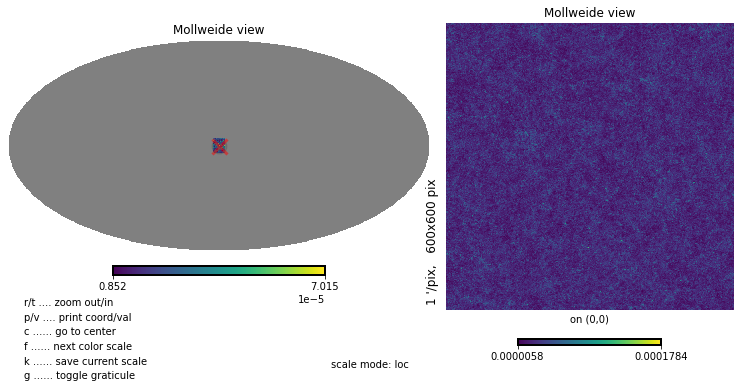

In [37]:
hp.mollzoom(map_high)


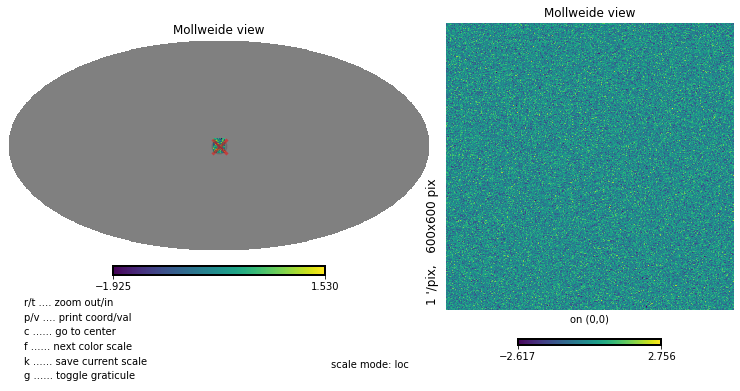

In [50]:
hp.mollzoom(map_high_noise+map_low)


# Save maps_

In [40]:
hp.write_map("../../maps/map_2lines_noiseless.fits", map_high+map_low, overwrite=True)


setting the output map dtype to [dtype('float64')]


In [46]:
#add noise
CO_high.update(Tsys=4*u.K)

In [47]:
map_high_noise = CO_high.obs_2d_map

In [51]:
hp.write_map("../../maps/map_2lines_noise.fits", map_high_noise+map_low, overwrite=True)


setting the output map dtype to [dtype('float64')]


# Halo catalog

In [23]:
from astropy.io import fits


In [24]:
CO_high.halo_catalog

/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_0.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_1.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_2.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_3.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_4.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_5.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_6.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_7.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_8.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_9.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_10.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_11.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_12.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_13.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_14.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_15.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_16.fits
/home/jlbernal/LightCone

/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_141.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_142.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_143.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_144.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_145.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_146.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_147.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_148.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_149.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_150.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_151.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_152.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_153.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_154.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_155.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_156.fits
/home/jlbernal/LightCone_S82_UM/lightcone_MDPL2UM_157.fi

array([(-2.8376331, -2.1186316, 0.00409733, -0.00081954,       12577961440, 7.8130997e+11, 3.7853590e+10, 2.7024915 ),
       (-2.2731044, -1.5934242, 0.00409954, -0.00076745, 14000010432228948, 4.0745234e+10, 0.0000000e+00, 0.        ),
       (-2.726137 , -2.0398452, 0.00409357, -0.00099676,  4000011981312656, 3.4581271e+10, 0.0000000e+00, 0.        ),
       ...,
       ( 4.802085 , -4.999294 , 3.904706  , -0.00209889,        1144408718, 3.1613999e+10, 1.5698011e+07, 0.1802134 ),
       ( 4.815204 , -4.9754243, 3.912087  , -0.00293661,        1144047984, 1.5807000e+10, 1.6913580e+06, 0.02406465),
       ( 4.827076 , -4.971929 , 3.9089913 , -0.00216509,        1144037269, 4.3656999e+10, 8.9370950e+06, 0.1045992 )],
      dtype=(numpy.record, [('RA', '>f4'), ('DEC', '>f4'), ('Z', '>f4'), ('DZ', '>f4'), ('ID', '>i8'), ('M_HALO', '>f4'), ('SM_HALO', '>f4'), ('SFR_HALO', '>f4')]))

In [30]:
c1 = fits.Column(name='RA', array=CO_high.halo_catalog['RA'], format='E')
c2 = fits.Column(name='DEC', array=CO_high.halo_catalog['DEC'], format='E')
c3 = fits.Column(name='Z', array=CO_high.halo_catalog['Z'], format='E')
c4 = fits.Column(name='DZ', array=CO_high.halo_catalog['DZ'], format='E')
c5 = fits.Column(name='M_HALO', array=CO_high.halo_catalog['M_HALO'], format='E')
c6 = fits.Column(name='SM_HALO', array=CO_high.halo_catalog['SM_HALO'], format='E')
c7 = fits.Column(name='SFR_HALO', array=CO_high.halo_catalog['SFR_HALO'], format='E')


t = fits.BinTableHDU.from_columns([c1, c2, c3,c4,c5,c6,c7])
t.writeto('../../maps/halo_catalog.fits')

# Check maps

In [6]:
map1 = hp.read_map("../../maps/map_2lines_noiseless.fits")
map2 = hp.read_map("../../maps/map_2lines_noise.fits")



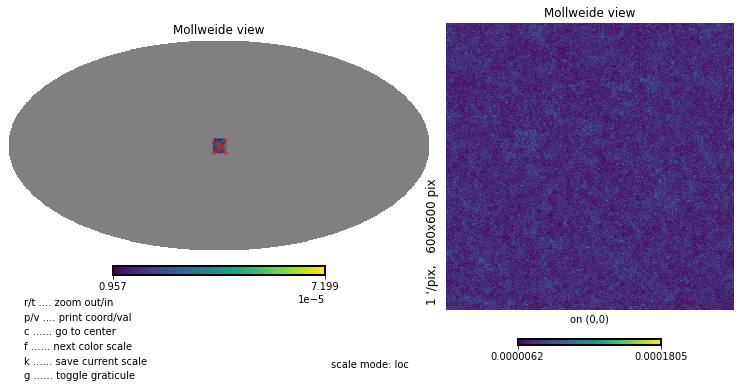

In [7]:
hp.mollzoom(map1)


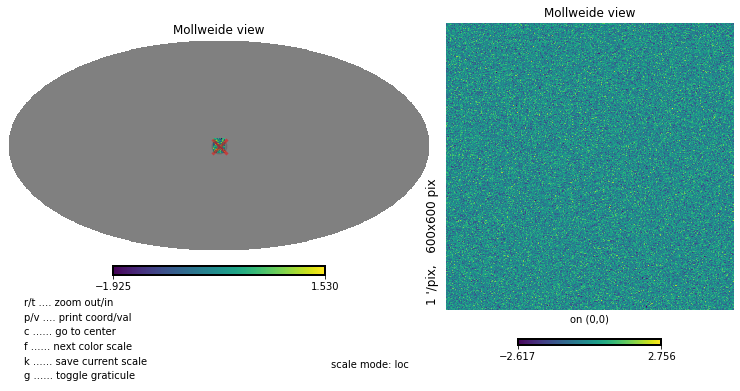

In [8]:
hp.mollzoom(map2)


In [31]:
hdul = fits.open('../../maps/halo_catalog.fits')